In [48]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os

# Collect

In [49]:
pfiles = []

In [50]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [65]:
def get_df(pfiles):
    dist_data = {'fnames': [], 'vals': [], 'idxs': []}
    dim_data = {'fnames': [], 'dims': []}
    slope_data = {'fnames': [], 'slopes': []}
    
    results = {}
    for pfile in pfiles:
        with open(pfile, 'rb') as f:
            _results = pickle.load(f)
        for key in _results.keys():
            if key not in results.keys(): results[key] = []
            results[key].extend(_results[key])
    for fname in np.unique(results['fname']):
        criteria = np.array(results['fname']) == fname
        fname = fname.split('_')[-1]
        if 'smaller' in fname: continue
        criteria = np.logical_and(
            criteria, [v[-1] > 190 for v in results['valid_scores']]
            )
        print(np.sum(criteria))
        idxs = np.argwhere(criteria).squeeze()
        if idxs.size == 1:
            idxs = idxs.reshape((-1,))
        if np.sum(idxs) == 0: continue
        _matrices = [results['separability_matrix'][i] for i in idxs]
        
        _new_matrices = []
        for _m in _matrices:
            _m = _m/np.nanpercentile(_m, 99)
            _new_matrices.append(_m)
        _matrices = _new_matrices
        
        _matrices_mean = np.nanmean(_matrices, axis=0)
        _slopes = [results['separability_slope'][i] for i in idxs]
        _dims = [results['dimensionality_tracking'][i] for i in idxs]
#         for _m in _matrices:
#             height = _m.shape[0]//4
#             plt.figure()
#             plt.title(fname)
#             plt.imshow(_m, vmin=0, vmax=0.9)
#             for boundary in [0, height, height*2, height*3]:
#                 plt.axhline(boundary-0.5, linewidth=2, color='white')
#                 plt.axvline(boundary-0.5, linewidth=2, color='white')
#             plt.xticks(
#                 np.linspace(0, _matrices_mean.shape[0]-0.5, num=9, endpoint=True)[1::2],
#                 ['Left', 'Central-L', 'Central-R', 'Right'], rotation=30)
#             plt.yticks(
#                 np.linspace(0, _matrices_mean.shape[0]-0.5, num=9, endpoint=True)[1::2],
#                 ['Left', 'Central-L', 'Central-R', 'Right'])
#             plt.colorbar()
#             plt.show()

        height = _matrices_mean.shape[0]//4
        for i in range(height):
            for _matrix in _matrices:
                dist_data['fnames'].append(fname)
                dist_data['vals'].append(_matrix[height+i, height*2+i])
                dist_data['idxs'].append(i)
        dim_data['fnames'].extend(_dims)
        dim_data['dims'].extend([fname]*len(_dims))
        slope_data['fnames'].extend(_slopes)
        slope_data['slopes'].extend([fname]*len(_dims))

        plt.figure()
        plt.title(fname)
        plt.imshow(_matrices_mean)#, vmin=0, vmax=0.9)
        for boundary in [0, height, height*2, height*3]:
            plt.axhline(boundary-0.5, linewidth=2, color='white')
            plt.axvline(boundary-0.5, linewidth=2, color='white')
        plt.xticks(
            np.linspace(0, _matrices_mean.shape[0]-0.5, num=9, endpoint=True)[1::2],
            ['Left', 'Central-L', 'Central-R', 'Right'], rotation=30)
        plt.yticks(
            np.linspace(0, _matrices_mean.shape[0]-0.5, num=9, endpoint=True)[1::2],
            ['Left', 'Central-L', 'Central-R', 'Right'])
        plt.colorbar()
        plt.show()
    dist_df = pd.DataFrame(dist_data)
    dim_df = pd.DataFrame(dim_data)
    return dist_data, dim_data, slope_data

25


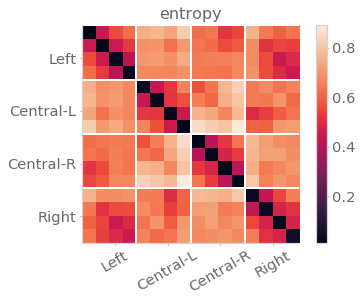

36


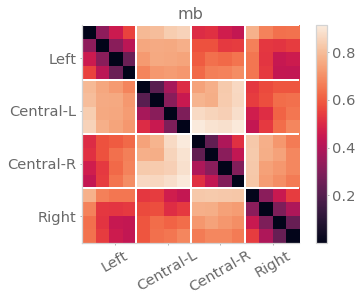

33


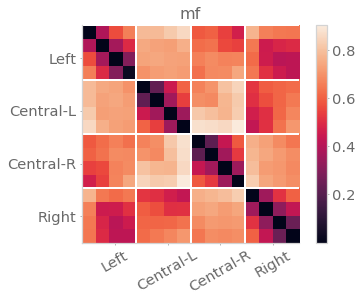

In [66]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/altTT1_dm_dim10/'
for pfile in os.listdir(pickle_dir):
    pfiles.append(f'{pickle_dir}{pfile}')
dist_data, dim_data, slope_data = get_df(pfiles)

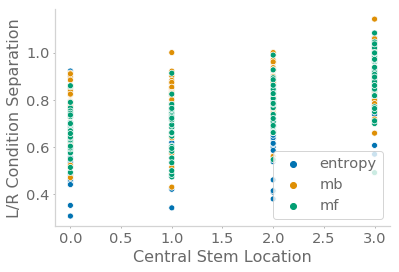

In [67]:
plt.figure()
sns.scatterplot(
    x='idxs', y='vals', hue='fnames', data=dist_data
    )
plt.ylabel('L/R Condition Separation')
plt.xlabel('Central Stem Location')
#plt.ylim(0, 1)
#plt.xticks([0, 2, 4], ['Reset', 'Middle', 'Decision Point'])
plt.show()

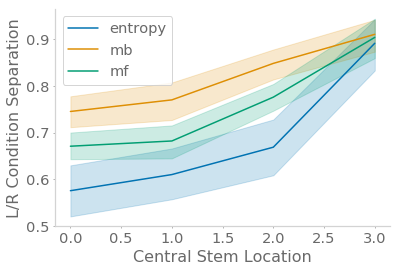

In [68]:
plt.figure()
sns.lineplot(
    x='idxs', y='vals',hue='fnames', data=dist_data
    )
plt.ylabel('L/R Condition Separation')
plt.xlabel('Central Stem Location')
#plt.xticks([0, 2, 4], ['Reset', 'Middle', 'Decision Point'])
plt.show()

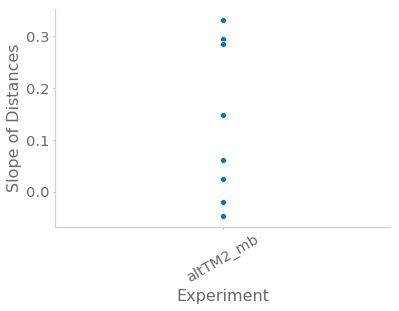

In [19]:
plt.figure()
sns.scatterplot(y='fnames', x='slopes', data=slope_data)
plt.ylabel('Slope of Distances')
plt.xlabel('Experiment')
plt.xticks(rotation=30)
plt.show()

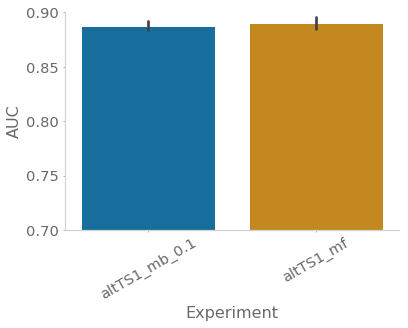

In [230]:
plt.figure()
sns.barplot(
    y='fnames', x='dims', data=dim_data
    )
plt.ylim(0.7, 0.9)
plt.ylabel('AUC')
plt.xlabel('Experiment')
plt.xticks(rotation=30)
plt.show()